# Object Tracking with Color

The following process is broken down into a 2 step approach:

1. Color Filtering
    - Convert from BGR to HSV
    - Find the min and max thresholds
2. Contour Finding
    - Find the Contours
    - Track the moments

**NOTES**:
* Colored objects are easier to filter in the HSV color space. For more information on HSV: https://en.wikipedia.org/wiki/HSL_and_HSV#Use_in_image_analysis
* The **R, G, and B components** of an object’s color in a digital image **are all correlated with the amount of light** hitting the object. Thus, image descriptions in terms of those components make object discrimination difficult. Descriptions in terms of hue/lightness/saturation are often more relevant. Colors in the HSV format glow brightly and thus are easier to filter.

In [1]:
'''
Import useful libraries
'''
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import datetime
import csv

matplotlib.style.use('ggplot')
cv2.setUseOptimized(True)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
'''
Importing Video file
'''
video = 'C:/Users/RR5033675/Documents/Python Scripts/1.Walk_Video_Color_Tracking/Data/shahar_walk.avi'
capture = cv2.VideoCapture(video)
print capture.isOpened() # should return True only, else configure ffmpeg

True


In [4]:
'''
Frame & Frame rate
'''
total_frames = capture.get(cv2.CAP_PROP_FRAME_COUNT)
print 'Total number of frames in the video:', int(total_frames)

frame_rate = capture.get(cv2.CAP_PROP_FPS)
print 'Frame rate of the video: ', frame_rate

Total number of frames in the video: 83
Frame rate of the video:  25.0


In [5]:
'''
Play video (press q to quit)
'''
while(capture.isOpened()):

    ret, frame = capture.read()
    
    cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
    cv2.imshow('frame', frame)
        
    # press q to quit the video
    if cv2.waitKey(120) & 0xFF == ord('q'): 
        break

    
# end video
capture.release()
cv2.destroyAllWindows()

In [ ]:
'''
Extracting frames
'''
count = 0
success = True

while success:
    success, image = capture.read()
    print 'Read a new frame: ', success
    cv2.imwrite("frame_walk%d.jpg" % count, image)# save frame as JPEG file
    
    if cv2.waitKey(10) == 1:                     # exit if Escape is hit
        break
        
    count += 1

In [6]:
'''
Using median frame for further analysis
'''
image = cv2.imread('C:/Users/RR5033675/Documents/Python Scripts/1.Walk_Video_Color_Tracking/frame_walk43.jpg')

### Step1: Color Filtering

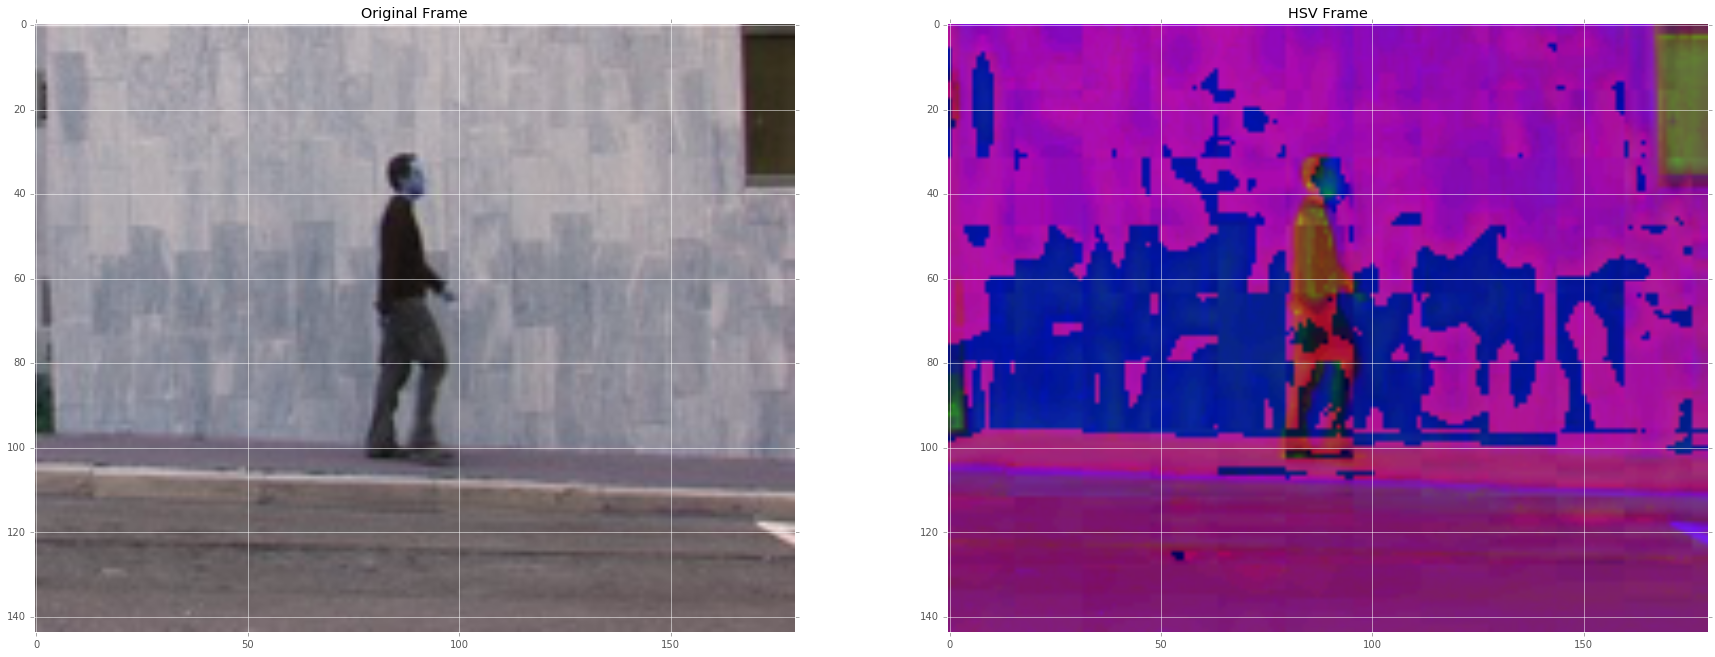

In [7]:
'''
Show train frame
'''
hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

plt.figure(figsize=(30,15))

plt.subplot(121)
plt.imshow(image)
plt.title('Original Frame')

plt.subplot(122)
plt.imshow(hsv_img)
plt.title('HSV Frame')

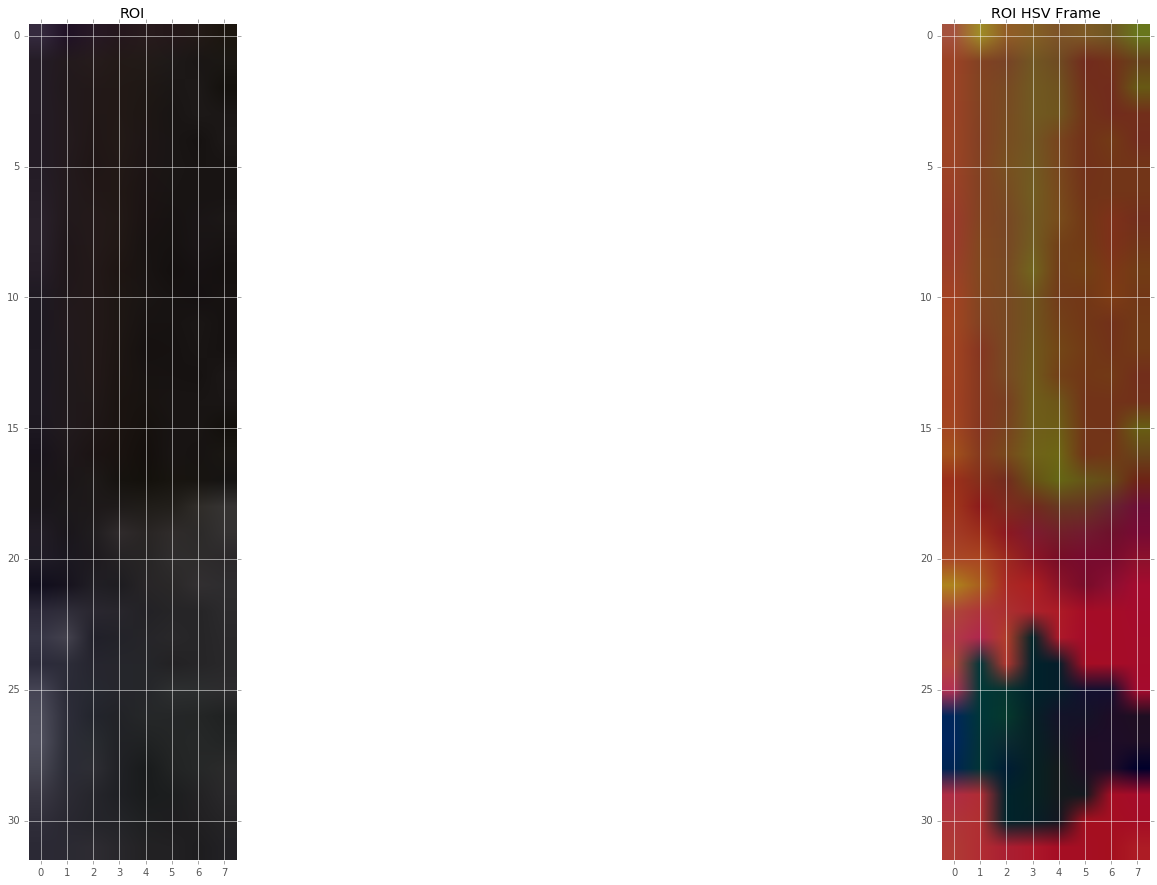

In [8]:
'''
Extract ROI from train frame
'''
roi = image[47:79, 82:90]
roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
roi.shape

plt.figure(figsize=(30,15))

plt.subplot(121)
plt.imshow(roi)
plt.title('ROI')

plt.subplot(122)
plt.imshow(roi_hsv)
plt.title('ROI HSV Frame')

In [9]:
'''
ROI Shape
'''
print 'width of the roi: ', roi.shape[0]
print 'height of the roi: ', roi.shape[1]

width of the roi:  32
height of the roi:  8


In [10]:
'''
Read all HSV values and adjust thresholds
'''

# empty numpy arrays to store h,s,v values
h = np.empty((0,roi.shape[0]*roi.shape[2]))
s = np.empty((0, roi.shape[0]*roi.shape[2]))
v = np.empty((0, roi.shape[0]*roi.shape[2]))

# nested for loop to read h,s,v for each pixel
for i in range(0,roi.shape[0]):
    for j in range(0,roi.shape[1]):
        h = np.append(h, roi[i,j,0])
        s = np.append(s, roi[i,j,1])
        v = np.append(v, roi[i,j,2])

print 'Total pixels scanned: ', h.shape[0]
print '\n'

#print min and max h,s,v values
print "min h value found from roi pixels: ", h.min()
print "max h value found from roi pixels: ", h.max()
print "min s value found from roi pixels: ", s.min()
print "max s value found from roi pixels: ", s.max()
print "min v value found from roi pixels: ", v.min()
print "max v value found from roi pixels: ", v.max()
print '\n'

#print final threshold values
print 'threshold limits for h (min,max): ', h.min()-5, h.max()+5
print 'threshold limits for s (min,max): ', s.min()-5, s.max()+5
print 'threshold limits for v (min,max): ', v.min()-5, v.max()+5

Total pixels scanned:  256


min h value found from roi pixels:  17.0
max h value found from roi pixels:  80.0
min s value found from roi pixels:  14.0
max s value found from roi pixels:  80.0
min v value found from roi pixels:  12.0
max v value found from roi pixels:  94.0


threshold limits for h (min,max):  12.0 85.0
threshold limits for s (min,max):  9.0 85.0
threshold limits for v (min,max):  7.0 99.0


In [11]:
'''
Add threshold mask
'''

# apply limits
lower_roi = np.array([12,9,7])
upper_roi = np.array([85,85,99])

# apply mask
mask = cv2.inRange(hsv_img, lower_roi, upper_roi)
res = cv2.bitwise_and(image,image, mask = mask)

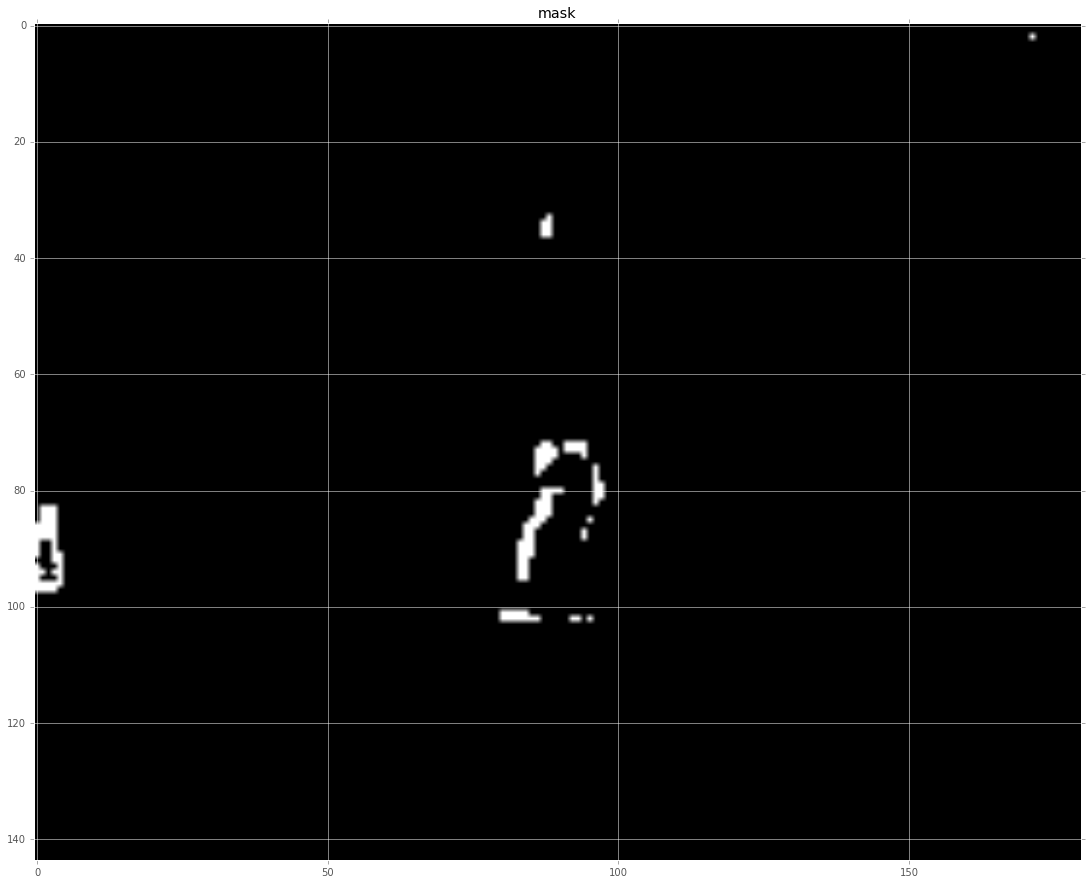

In [12]:
plt.figure(figsize=(30,15))
plt.imshow(mask, 'gray')
plt.title('mask')

#cv2.namedWindow('mask', cv2.WINDOW_NORMAL) # cv2.WINDOW_NORMAL allows re-sizing of windows
#cv2.imshow('mask', mask)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

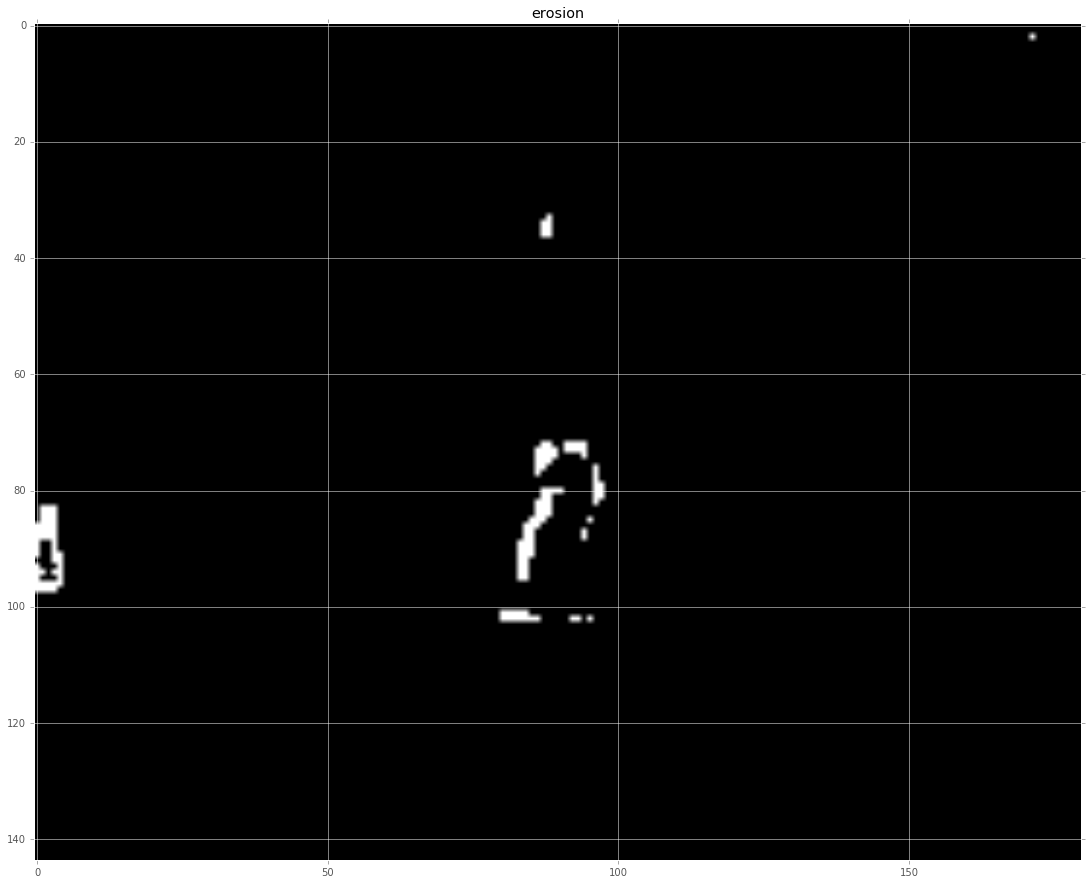

In [13]:
'''
Perform Morphological Smoothing
'''

# the bigger the kernel, the greater the number of pixels checked for erosion at a particular point - 
# think of it as a rectangle of pixels with a certain strenght
# Kernel value to be found by trial-and-error
# the number of iterations controls the strength of the erosion as well, 
# the higher the erosion the greater the strength.

kernel = np.ones((1,1),np.uint8)
erosion = cv2.erode(mask,kernel,iterations = 1)

plt.figure(figsize=(30,15))
plt.imshow(erosion, 'gray')
plt.title('erosion')

#cv2.namedWindow('erosion', cv2.WINDOW_NORMAL)
#cv2.imshow('erosion', erosion)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

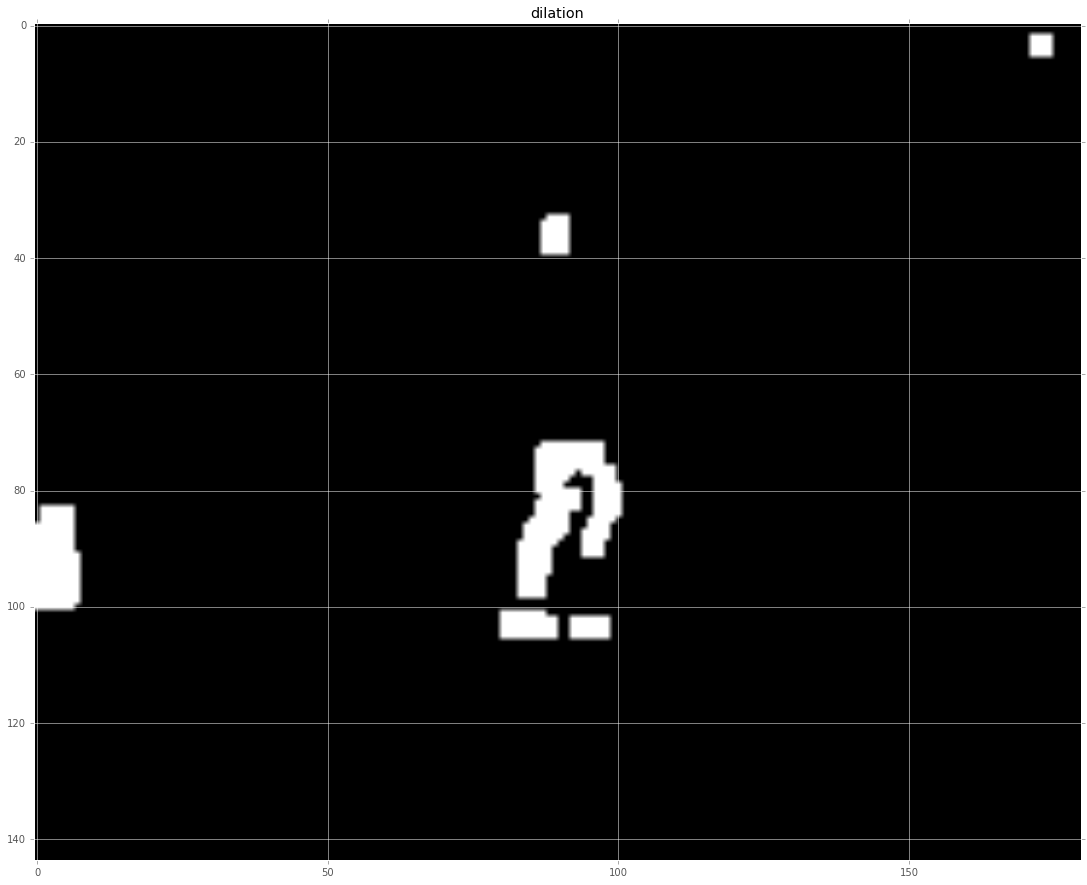

In [14]:
# dilating the image after erosion to fix the missing pixels

kernel = np.ones((2,2),np.uint8)
dilation = cv2.dilate(erosion,kernel,iterations = 3)

plt.figure(figsize=(30,15))
plt.imshow(dilation, 'gray')
plt.title('dilation')

#cv2.namedWindow('dilation', cv2.WINDOW_NORMAL)
#cv2.imshow('dilation', dilation)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

# Contour Filtering

**Step1:** Use the findContours() function to find the outline of all objects founds in the binary image. 
* *Input: *binary image
* *Output: *vector of contours

**Step2:** Use the Moments method to find the tracking coordinates
* *Input: *Vector of Contours
* *Output: *x,y coordinates of largest contour defined by its inner area.

In [15]:
ll, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(image, contours, -1, (0,255,0), 3)
print 'Number of Contours found: ', len(contours)

Number of Contours found:  6


In [16]:
font = cv2.FONT_HERSHEY_SIMPLEX

for i in range(0, len(contours)):
    cnt = contours[i]
    area = cv2.contourArea(cnt)

    if area > 100:
        M = cv2.moments(cnt)
        x = int(M['m10']/area)
        y = int(M['m01']/area)
        
        string = "(" + str(x) + "," + str(y) + ")" 
        cv2.circle(image,(x,y), 1, (0,0,255), -1)
        cv2.putText(image, string, (x,y+30), font, 0.5, (0,0,255),1,1)

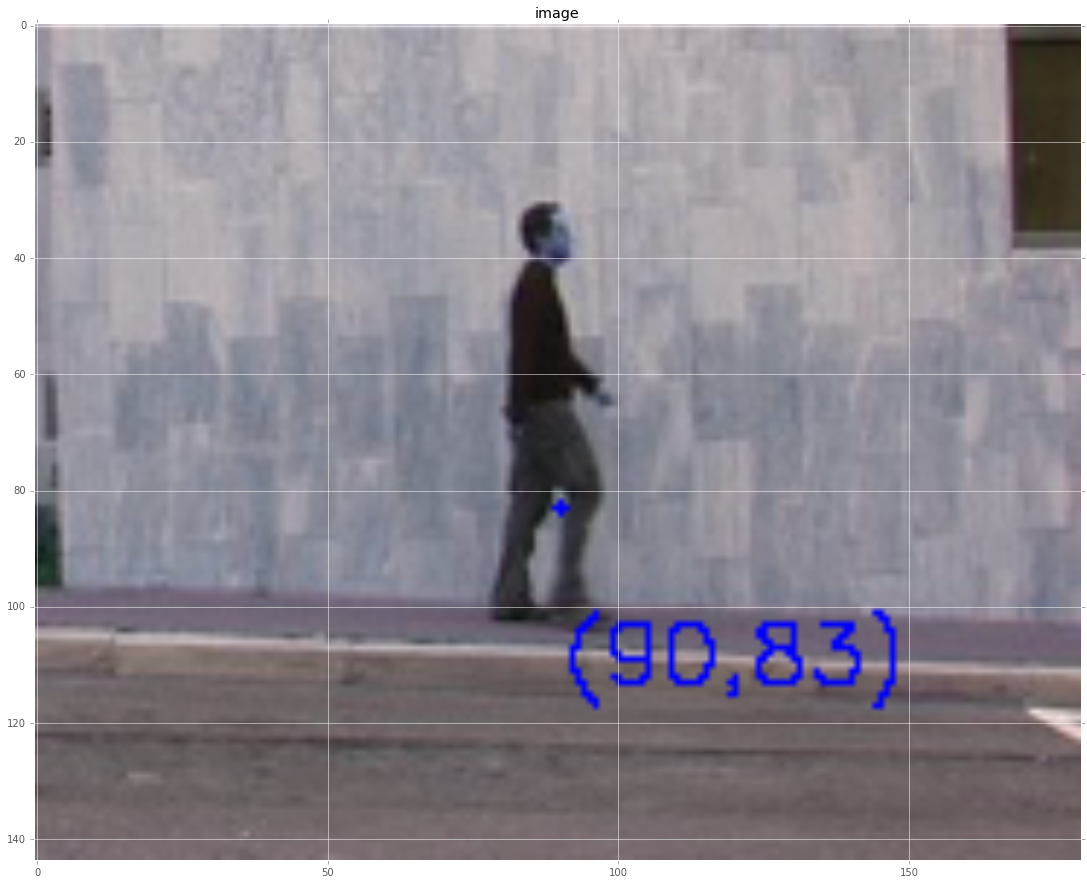

In [17]:
plt.figure(figsize=(30,15))
plt.imshow(image, 'gray')
plt.title('image')

#cv2.namedWindow('image', cv2.WINDOW_NORMAL)
#cv2.imshow('image', image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

# Demo

In [3]:
'''
Apply above analysis on the video
'''
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import datetime
import csv

video = 'C:/Users/RR5033675/Documents/Python Scripts/1.Walk_Video_Color_Tracking/Data/shahar_walk.avi'
capture = cv2.VideoCapture(video)

f = open('myfile.txt', 'w')

while(capture.isOpened()):
    
    # read each frame
    ret, frame = capture.read() 
    
    # convert frame to hsv
    hsv_f = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # define lower and upper thresholds
    lower_roi = np.array([12,9,7])
    upper_roi = np.array([85,85,99])

    # apply mask
    mask = cv2.inRange(hsv_f, lower_roi, upper_roi)
    res = cv2.bitwise_and(frame,frame, mask = mask)
    
    # Morphological Smoothing 
    kernel = np.ones((1,1),np.uint8)
    erosion = cv2.erode(mask,kernel,iterations = 1)
    kernel = np.ones((2,2),np.uint8)
    dilation = cv2.dilate(erosion,kernel,iterations = 3)
    
    # Define Contours
    ll, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) #check the params
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # Calculate time
    system_time = datetime.datetime.now().time()
    time = str(system_time)
    hours = time[0:2]
    minutes = time[3:5]
    seconds = time[6:8]
    timestamp = str(minutes) + ":" + str(seconds)
    #print timestamp
    
    # segment blobs using contour area
    for i in range(0, len(contours)):
       
        cnt = contours[i]
        area = cv2.contourArea(cnt)
        
        if area > 115: # number determined by trial & error
            M = cv2.moments(cnt)
            x = int(M['m10']/area)
            y = int(M['m01']/area)
            string = "(" + str(x) + "," + str(y) + ")" 
            cv2.circle(frame,(x,y), 1, (0,255,0), -1)
            cv2.putText(frame, string, (x,y+30), font, 0.5, (0,255,0),1,1)
            write = str(x) + ',' + str(y) + ',' + timestamp + '\n'
            f.write(write)
    
    # Add timestamp to the frame
    cv2.rectangle(frame, (0,120), (70,140),(255,255,255),-1)
    cv2.putText(frame, timestamp, (0,140), 1, 1, (0,0,0),1,1)
    
    # show final
    cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
    cv2.imshow('frame', frame)
    
    # press q to quit the video
    if cv2.waitKey(150) & 0xFF == ord('q'): 
        break

# end video
capture.release()
cv2.destroyAllWindows()

In [4]:
f.close()

# Analysis

Analysis is done based on the information found in the text file above

In [5]:
import math

num_track_points = 81

max_x = 166
min_x = 4

max_y = 70
min_y = 65

direc = max_x - min_x

direction = "Right"

if direc < 0:
    direction = "Left"

print "The number of tracked point: ", num_track_points
print "The direction of walking: ", direction

The number of tracked point:  81
The direction of walking:  Right


![analysis](./Data/analysis2.png)

In [6]:
dist = math.sqrt(math.pow((max_y - min_y),2) + math.pow((max_x - min_x),2))
time = 13
speed = dist/time

print "The distance traveled: ", dist, " units"
print "The time taken is: ", time, "seconds"
print "Speed: ", speed, " units/seconds"

The distance traveled:  162.077142127  units
The time taken is:  13 seconds
Speed:  12.4674724713  units/seconds


# Drawbacks

* The object of interest is to be known before-hand
* A drastic change in color can make the object unidentifiable
* Train image sample needed

In [1]:
# add links to multiple tracking color object and advanced vid